In [3]:
%matplotlib inline

import os
import json
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "../../data/ccks2020_el_data_v1"

In [4]:
!ls $data_path

CCKS 2020 Entity Linking License.docx  EL_FEATURE_VALID.pkl  train.json
dev.json			       eval.py		     train_link_all.tsv
dev_link_all.tsv		       id_to_type.txt	     train_link.tsv
dev_link.tsv			       kb.json		     train_type.csv
dev_type.csv			       README
EL_FEATURE_TRAIN.pkl		       test.json


In [5]:
!head $data_path/dev.json

{"text_id": "1", "text": "天下没有不散的宴席 - ╰つ雲中帆╰つ", "mention_data": [{"kb_id": "28270", "mention": "天下没有不散的宴席", "offset": "0"}, {"kb_id": "NIL_Other", "mention": "╰つ雲中帆╰つ", "offset": "12"}]}
{"text_id": "2", "text": "永嘉厂房出租", "mention_data": [{"kb_id": "81944", "mention": "永嘉", "offset": "0"}, {"kb_id": "252045", "mention": "厂房", "offset": "2"}, {"kb_id": "211585", "mention": "出租", "offset": "4"}]}
{"text_id": "3", "text": "《我是猫》([日]夏目漱石)【摘要 书评 试读】", "mention_data": [{"kb_id": "152866", "mention": "我是猫", "offset": "1"}, {"kb_id": "276248", "mention": "夏目漱石", "offset": "9"}, {"kb_id": "292943", "mention": "摘要", "offset": "15"}, {"kb_id": "237606", "mention": "书评", "offset": "18"}]}
{"text_id": "4", "text": "《中国作家》2013年度排行榜", "mention_data": [{"kb_id": "56993", "mention": "中国作家", "offset": "1"}, {"kb_id": "226030", "mention": "年度", "offset": "10"}, {"kb_id": "110815", "mention": "排行榜", "offset": "12"}]}
{"text_id": "5", "text": "《大叔时代》_胶带纸著_都市", "mention_data": [{"kb_id": "190789", "mention"

In [9]:
!tail $data_path/"kb.json"

{"alias": ["董氏针灸", "氏董针灸"], "subject_id": "334409", "data": [{"predicate": "摘要", "object": "董氏奇穴针灸学是董氏先祖创立的独具特色的针灸体系，内容博大精深，包含针法甚广，诸如耳针、头皮针、手针、倒马针、放血疗法等，内容不但丰富异于传统，且治法简便而疗效显著，是台湾本土所独有的针法。"}, {"predicate": "义项描述", "object": "董氏先祖创立的针灸体系"}, {"predicate": "中文名", "object": "董氏奇穴针灸学"}, {"predicate": "标签", "object": "医学、科学、书籍"}], "type": "Other", "subject": "董氏奇穴针灸学"}
{"alias": ["试题与研究"], "subject_id": "334410", "data": [{"predicate": "主办单位", "object": "中学生学习报社"}, {"predicate": "摘要", "object": "《试题与研究》是为广大中学师生服务的期刊。"}, {"predicate": "语言", "object": "中文"}, {"predicate": "主管单位", "object": "中原出版传媒集团"}, {"predicate": "国内刊号", "object": "41-1368/G4"}, {"predicate": "国际刊号", "object": "1673-1301"}, {"predicate": "中文名称", "object": "试题与研究"}, {"predicate": "义项描述", "object": "中考初中生练习题"}, {"predicate": "类别", "object": "中考"}, {"predicate": "创刊时间", "object": "1978年"}, {"predicate": "标签", "object": "期刊、出版物、书籍"}], "type": "Other", "subject": "试题研究"}
{"alias": ["生物制药"], "subject_id": "334411", "data": [{"pred

在我们的knowledge base中，每个entity都存在很多的attributes。我们把一个entity所有的attribute全部拼接到一起作为entity的一种表示。

In [10]:
entity_to_kbids = defaultdict(set)
kbid_to_entities = dict()
kbid_to_text = dict()
kbid_to_types = dict()

idx_to_type = []
type_to_idx = dict()

with open(os.path.join(data_path, 'kb.json'), 'r') as f:
    for i, line in enumerate(f):
        temp = json.loads(line)
        
        kbid = temp['subject_id']
        entities = set(temp['alias'])
        entities.add(temp['subject'])
        for entity in entities:
            entity_to_kbids[entity].add(kbid)
        kbid_to_entities[kbid] = entities
        
        data_list = []
        for x in temp['data']:
            data_list.append(':'.join([x['predicate'], x['object'].strip().replace("\n", " ").replace("\t", " ").replace("\r", " ")]))
        kbid_to_text[kbid] = ' '.join(data_list)
        
        type_list = temp['type'].split('|')
        kbid_to_types[kbid] = type_list
        for t in type_list:
            if t not in type_to_idx:
                type_to_idx[t] = len(idx_to_type)
                idx_to_type.append(t)

我们把id和type之间的关系写到文件中方便后续使用。

In [11]:
with open(os.path.join(data_path, "id_to_type.txt"), "w") as fout:
    for t in idx_to_type:
        fout.write(t + "\n")

In [12]:
kbid_to_text

{'10001': '政治面貌:中共党员 义项描述:潜山县塔畈乡副主任科员、纪委副书记 性别:男 学历:大专 中文名:张健',
 '10002': '首播时间:2018年2月7日 摘要:《圣途》是由李阳执导的五集大型纪录片。 国家/地区:中国大陆 总策划:洪涛 播出频道:CCTV1、CCTV4、四川、云南、西藏、青海、甘肃等 播出状态:已播。 导演组:高军、周丽蕴、潘潘、刘令湜 导演:李阳 撰稿:何力、李东舒、卫夙谨、杨曼等 每集长度:30分钟 外文名称:Sacred journey 中文名称:圣途 义项描述:2018年李阳执导的五集纪录片 播出时间:2018年2月7日 类型:纪录片 在线播放平台:CNTV',
 '10003': '出生地:江苏省东海县 摘要:李明，男，汉族，江苏东海人，祖籍通州。 中文名:李明 代表作品:《管管网吧救救孩子》《小李与世界很近》 义项描述:中国作家协会会员 主要成就:作品获全国党报群众工作记者协会一等奖 国籍:中国 出生日期:1964年 职业:记者 民族:汉 标签:人物',
 '10004': '摘要:江山市医学会秘书长。 职业:江山市医学会秘书长 中文名:陈臻 义项描述:江山市医学会秘书长 国籍:中国 性别:男 标签:人物',
 '10005': '摘要:爱新觉罗·承志是辅国公西朗阿之子。 义项描述:爱新觉罗·承志 标签:人物、话题人物、历史',
 '10006': '义项描述:复方口服避孕药',
 '10007': '摘要:王建平，现任广东省高级人民法院民事审判第一庭庭长。 任命时间:2017年9月28日 职务:民事审判第一庭庭长 工作单位:广东省高级人民法院 中文名:王建平 义项描述:广东省高级人民法院民事审判第一庭庭长',
 '10008': '摘要:《海盗》是美国作家霍华德·派尔创作的故事集，首次出版于1908年。 首版时间:1908年 作品名称:海盗 作者:霍华德·派尔 义项描述:霍华德·派尔创作故事集 文学体裁:故事集',
 '10009': '摘要:原型，游戏名称，主角Alex Mercer是一名有着奇异力量的黑暗英雄。 义项描述:游戏 标签:游戏',
 '10010': '摘要:《光》是歌手魏晨的专辑《登“封”造极》中的一首歌曲。 谱曲:韩星洲 歌曲时长:3分23秒 歌曲原唱:魏晨 填词:魏晨，韩星洲 中文名称:光

In [50]:
[t for t in kbid_to_text.values() if "摘要:中毒的相关知识" in t]

['摘要:中毒的相关知识  1.什么是中毒？  当外界某化学物质进入人体后，与人体组织发生反应，引起人体发生暂时或持久性损害的过程称为中毒。 常见症状:头晕，出汗，恶心，呕吐，胸闷，腹部不适，腹痛，腹泻，昏迷 英文名称:intoxication 就诊科室:急诊科 义项描述:汉语词语 传染性:无 常见病因:化学物质进入人体 标签:科学百科健康医疗分类、学科、科学百科疾病症状分类、科学']

In [13]:
print('知识库大小：', len(kbid_to_entities))
print('实体数量：', len(entity_to_kbids))
print('上位类型数量：', len(type_to_idx))

知识库大小： 324418
实体数量： 278668
上位类型数量： 24


我们来看看这个知识图谱之中是否存在大量重名的实体。

In [14]:
print('包含有大量KBID的实体：')
for k, v in entity_to_kbids.items():
    if len(v) > 100:
        print(k, len(v))

包含有大量KBID的实体：
张健 181
李明 229
杨林 107
王芳 146
刘涛 120
张明 157
张华 158
张宇 111
张建军 109
刘杰 156
陈涛 122
杨帆 128
李磊 103
刘斌 171
李峰 136
刘伟 206
王建国 133
陈刚 184
张敏 161
陈军 144
王伟 259
杨军 185
张涛 188
李平 175
陈斌 103
张辉 134
李强 220
王旭 112
张杰 157
李杰 156
刘波 137
李俊 146
无 352
王勇 261
高峰 152
王磊 169
杨光 128
杨波 168
新华村 109
王强 204
李超 117
刘健 102
陈勇 187
张磊 147
张伟 279
张勇 285
王东 112
李伟 253
王毅 120
王刚 181
刘强 162
陈平 119
刘军 228
刘敏 162
李红 101
王宏 135
张平 115
张建华 150
王峰 140
张军 199
陈华 120
张帆 105
李健 134
李静 134
刘勇 223
张强 149
刘辉 124
刘超 107
王鹏 147
王敏 164
李涛 147
张浩 103
李军 274
张毅 107
李林 107
王志刚 101
刘刚 150
张颖 101
王琳 104
李建华 130
王飞 110
万达广场 130
李刚 187
张宁 124
李勇 232
李莉 143
王俊 124
王涛 147
王军 234
刘畅 108
吴刚 107
王宁 103
李华 133
王健 203
刘洋 140
刘峰 123
石磊 118
杨斌 127
王林 118
黄勇 116
王宇 104
陈明 116
陈敏 117
杨明 105
张斌 151
刘鹏 101


我们会发现这些重名的实体都是一些非常常见的人名，这也就难怪了。

然后我们来看看这些句子究竟有多长。

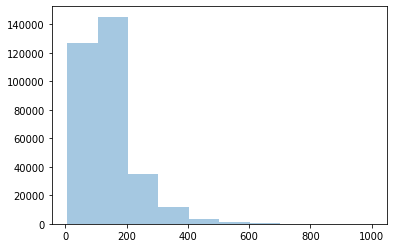

In [15]:
text_lengths = [min(1000, len(v)) for v in kbid_to_text.values()]
sns.distplot(text_lengths, kde=False, bins=10)
plt.show()

下面我们来构建一下entity linking的训练数据。这里的核心思想是，对于每一个entity mention，我们要找出所有可能指向的entity。其中一个是正确的entity，其余num_negs个是错误的entity。

In [16]:
def get_link_data(filename):
    link_dict = defaultdict(list)
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            temp = json.loads(line)

            for data in temp['mention_data']:
                if not data['kb_id'].isdigit():
                    continue

                entity = data['mention']
                kbids = entity_to_kbids[entity]

                num_negs = 0
                for kbid in kbids:
                    if kbid == data['kb_id']:
                        link_dict['entity'].append(entity)
                        link_dict['offset'].append(data['offset'])
                        link_dict['rawtext'].append(temp['text'])
                        link_dict['kbtext'].append(kbid_to_text[kbid])
                        link_dict['predict'].append(1)
                    else:
                        if num_negs >= 2:
                            continue
                        link_dict['entity'].append(entity)
                        link_dict['offset'].append(data['offset'])
                        link_dict['rawtext'].append(temp['text'])
                        link_dict['kbtext'].append(kbid_to_text[kbid])
                        link_dict['predict'].append(0)
                        num_negs += 1
    data = pd.DataFrame(link_dict)
    return data

In [17]:
train_link = get_link_data(os.path.join(data_path, 'train.json'))
train_link.to_csv(os.path.join(data_path, 'train_link.tsv'), index=False, sep='\t')

In [18]:
dev_link = get_link_data(os.path.join(data_path, 'dev.json'))
dev_link.to_csv(os.path.join(data_path, 'dev_link.tsv'), index=False, sep='\t')

In [25]:
train_link.head()

,entity,offset,rawtext,kbtext,predict
0,小品,0,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,摘要:小品，就是小的艺术品。 代表:喜剧小品 演艺注意事项:身心放松，自信 中文名:小品 特...,1
1,吴京,10,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,摘要:吴京，1914年12月20日生。 毕业院校:焦作工学院 中文名:吴京 义项描述:采矿机...,0
2,吴京,10,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,摘要:吴京，男，汉族，1980年10月出生，现公安局科技信息化和技术科科长。 职务:公安局科...,0
3,吴京,10,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,出生地:北京 外文名:Jason Wu、오 경（韩语） 摘要:吴京，1974年4月3日出生于...,1
4,障碍,16,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,外文名:Hazard 摘要:障碍（英文名：Hazard）是一种体育竞技术语。 距起跑点:27...,0


In [6]:
!head $data_path/dev.json

{"text_id": "1", "text": "天下没有不散的宴席 - ╰つ雲中帆╰つ", "mention_data": [{"kb_id": "28270", "mention": "天下没有不散的宴席", "offset": "0"}, {"kb_id": "NIL_Other", "mention": "╰つ雲中帆╰つ", "offset": "12"}]}
{"text_id": "2", "text": "永嘉厂房出租", "mention_data": [{"kb_id": "81944", "mention": "永嘉", "offset": "0"}, {"kb_id": "252045", "mention": "厂房", "offset": "2"}, {"kb_id": "211585", "mention": "出租", "offset": "4"}]}
{"text_id": "3", "text": "《我是猫》([日]夏目漱石)【摘要 书评 试读】", "mention_data": [{"kb_id": "152866", "mention": "我是猫", "offset": "1"}, {"kb_id": "276248", "mention": "夏目漱石", "offset": "9"}, {"kb_id": "292943", "mention": "摘要", "offset": "15"}, {"kb_id": "237606", "mention": "书评", "offset": "18"}]}
{"text_id": "4", "text": "《中国作家》2013年度排行榜", "mention_data": [{"kb_id": "56993", "mention": "中国作家", "offset": "1"}, {"kb_id": "226030", "mention": "年度", "offset": "10"}, {"kb_id": "110815", "mention": "排行榜", "offset": "12"}]}
{"text_id": "5", "text": "《大叔时代》_胶带纸著_都市", "mention_data": [{"kb_id": "190789", "mention"

In [20]:
def get_type_data(filename):

    type_dict = defaultdict(list)

    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            temp = json.loads(line)

            for data in temp['mention_data']:
                entity = data['mention']

                if data['kb_id'].isdigit():
                    entity_type = kbid_to_types[data['kb_id']]
                else:
                    entity_type = data['kb_id'].split('|')
                    for i in range(len(entity_type)):
                        entity_type[i] = entity_type[i][4:]
                for e in entity_type:
                    type_dict['entity'].append(entity)
                    type_dict['offset'].append(data['offset'])
                    type_dict['rawtext'].append(temp['text'])
                    type_dict['type'].append(e)
                    
    df = pd.DataFrame(type_dict)
    return df

In [21]:
train_type = get_type_data(os.path.join(data_path, "train.json"))
train_type.to_csv(os.path.join(data_path, 'train_type.csv'), index=False, sep='\t')
set(train_type['type'])

{'Awards',
 'Biological',
 'Brand',
 'Constellation',
 'Culture',
 'Diagnosis&Treatment',
 'Disease&Symptom',
 'Education',
 'Event',
 'Food',
 'Game',
 'Law&Regulation',
 'Location',
 'Medicine',
 'Natural&Geography',
 'Organization',
 'Other',
 'Person',
 'Software',
 'Time&Calendar',
 'Vehicle',
 'VirtualThings',
 'Website',
 'Work'}

In [22]:
dev_type = get_type_data(os.path.join(data_path, "dev.json"))
dev_type.to_csv(os.path.join(data_path, 'dev_type.csv'), index=False, sep='\t')
set(dev_type['type'])

{'Awards',
 'Biological',
 'Brand',
 'Constellation',
 'Culture',
 'Disease&Symptom',
 'Education',
 'Event',
 'Food',
 'Game',
 'Law&Regulation',
 'Location',
 'Medicine',
 'Natural&Geography',
 'Organization',
 'Other',
 'Person',
 'Software',
 'Time&Calendar',
 'Vehicle',
 'VirtualThings',
 'Website',
 'Work'}

In [24]:
train_type.head()

,entity,offset,rawtext,type
0,小品,0,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,Other
1,战狼故事,3,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,Work
2,吴京,10,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,Person
3,障碍,16,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,Other
4,爱人,20,小品《战狼故事》中，吴京突破重重障碍解救爱人，深情告白太感人,Other
